# MixedML on Python

Linear Mixed Effect: $$Y_{ij} = \beta_0 + \beta_i X_{ij} + b_{0j} + b_{ij} X_{ij} + \epsilon_{i}$$ 
=> MixedML: $$Y_{ij} = ML(X_{ij}) + b_{0j} + b_{ij} X_{ij} + \epsilon_{i}$$


with ML: any type of Machine Learning model


LCMM is used for the (pure) random effect model:


```R
random_hlme <- hlme(
  e_fixed ~ 1,
  random = ~  1 + x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8,
  idiag = TRUE,
  data = data,
  subject = 'individus',
  var.time = 'temps'
)
```

Algorithm initialization:  $Y_{fixed} = Y$  

Until convergence of $squared\_residuals$:  
|  
|$~~~~~ML.fit(X, Y_{fixed})$  
|$~~~~~Y_{rand} = Y - ML(X)$  
|  
|$~~~~~HLME.fit(X, Y_{rand})$  
|$~~~~~Y_{fixed} = Y - HLME(X)$  
|    
|$~~~~~Y_{pred} = ML(X) + HLME(X)$    
|$~~~~~squared\_residuals = (Y - Y_{pred})^2$  

In [1]:
from sys import path
from pathlib import Path


def add_path(p: str):
    pth = Path(p).resolve().as_posix()
    print(pth)
    path.append(pth)


add_path("../")
add_path("../../")

/home/francois/Documents/SISTM/subSISTM/models/mixedML
/home/francois/Documents/SISTM/subSISTM/models


In [2]:
import pickle
import seaborn as sns
from matplotlib.pyplot import subplots
from pandas import DataFrame
import pandas as pd
from reservoirpy import verbosity
from reservoirpy.nodes import Reservoir, Ridge
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import RobustScaler

from reservoirs_synthetic_bph.utils.reservoirs import ReservoirEnsemble
from reservoirs_synthetic_bph.utils.data import get_dataframe, prepare_data
from reservoirs_synthetic_bph.utils.global_config import N_WARMUPS
from reservoirs_synthetic_bph.utils.post_processing import METRIC, VAL, TGT
from mixed_ml import MixedMLEstimator

pd.options.display.float_format = "{:.3g}".format
verbosity(0)

Data folder: /home/francois/Documents/SISTM/subSISTM/data/synthetic_bph_1


0

In [3]:
X_LABELS = ["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8"]
Y_LABEL = "y_mixed_obs"
Y_LABELS_PRED = ["y_mixed", "y_mixed_obs"]
SERIES = "individus"
TSTEPS = "temps"


data_train = get_dataframe(
    "../../../data/synthetic_bph_1/simulation1.csv",
    x_labels=X_LABELS,
    y_labels=Y_LABELS_PRED,
)
data_test = get_dataframe(
    "../../../data/synthetic_bph_1/simulation2.csv",
    x_labels=X_LABELS,
    y_labels=Y_LABELS_PRED,
)

## Building the model 

Standard models can be used:

In [4]:
code_mlp = "MLP"
model_mlp = MLPRegressor((20, 10, 5), learning_rate="adaptive", max_iter=1000)
mixed_ml_mlp = MixedMLEstimator(model_mlp, recurrent_model=False, specific_dir=code_mlp)

Also recurrent ones:

In [5]:
code_rpy = "Reservoir"
model_rpy = ReservoirEnsemble(
    reservoir_kwargs={"units": 50}, ridge_kwargs={"ridge": 1e-1}
)
mixed_ml_rpy = MixedMLEstimator(model_rpy, recurrent_model=True, specific_dir=code_rpy)

## Training  

In [6]:
scaler_x = RobustScaler()
scaler_y = RobustScaler()

data_train_scaled = data_train[[SERIES, TSTEPS]].copy()
data_train_scaled[X_LABELS] = scaler_x.fit_transform(data_train[X_LABELS])
data_train_scaled[[Y_LABEL]] = scaler_y.fit_transform(data_train[[Y_LABEL]])

data_test_scaled = data_test[[SERIES, TSTEPS]].copy()
data_test_scaled[X_LABELS] = scaler_x.transform(data_test[X_LABELS])
data_test_scaled[[Y_LABEL]] = scaler_y.transform(data_test[[Y_LABEL]])

In [7]:
pkl_mlp = code_mlp + ".pkl"
try:
    mixed_ml_mlp = pickle.load(open(pkl_mlp, "rb"))
except:
    cvg_mlp = mixed_ml_mlp.fit(
        data_train_scaled,
        n_iter_improv=2,
        min_rltv_imrov=0.01,
        fixed_model_fit_options={},
    )
    pickle.dump(mixed_ml_mlp, open(pkl_mlp, "wb"))

In [8]:
pkl_rpy = code_rpy + ".pkl"
try:
    mixed_ml_rpy = pickle.load(open(pkl_rpy, "rb"))
except:
    mixed_ml_rpy.fit(
        data_train_scaled,
        n_iter_improv=2,
        min_rltv_imrov=0.01,
        fixed_model_fit_options={"warmup": N_WARMUPS},
    )
    pickle.dump(mixed_ml_rpy, open(pkl_rpy, "wb"))

<Axes: xlabel='step', ylabel='metric'>

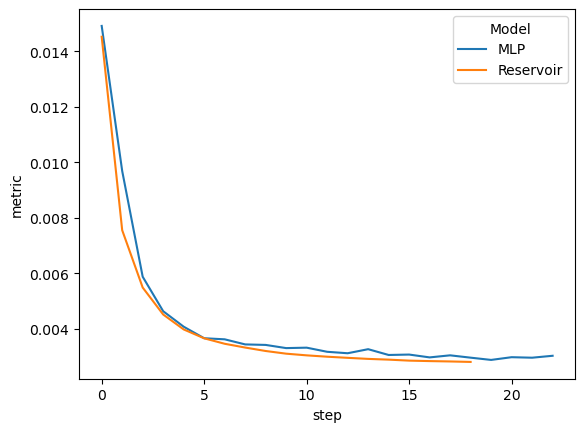

In [9]:
df_mlp = pd.read_csv(code_mlp + "/convergence-log.csv")
df_mlp["Model"] = code_mlp
df_rpy = pd.read_csv(code_rpy + "/convergence-log.csv")
df_rpy["Model"] = code_rpy

df_plot = pd.concat([df_mlp, df_rpy])
sns.lineplot(df_plot, x="step", y="metric", hue="Model")

## Predictions

In [10]:
def get_metrics(mixed_ml_mlp, mixed_ml_rpy, data, data_scaled, scaler_y):
    lres = []
    for name, model in {"MLP": mixed_ml_mlp, "Reservoir": mixed_ml_rpy}.items():
        for subspec in [True, False]:
            for tgt_name in Y_LABELS_PRED:
                y_pred_scaled = model.predict(data_scaled, use_subject_specific=subspec)
                y_pred_scaled = y_pred_scaled.reshape((len(y_pred_scaled), 1))
                y_pred = scaler_y.inverse_transform(y_pred_scaled)

                # we do not use the warmup: it's just an example notebook…
                for met in [mae, mse]:
                    lres.append(
                        {
                            "model": name,
                            "ss": subspec,
                            TGT: tgt_name,
                            METRIC: met.__name__,
                            VAL: met(data[tgt_name], y_pred),
                        }
                    )
    return DataFrame(lres)

### Predictions on train set

In [11]:
metric_train = get_metrics(
    mixed_ml_mlp, mixed_ml_rpy, data_train, data_train_scaled, scaler_y
)

In [12]:
metric_train.pivot(index=[METRIC, "model"], columns=[TGT, "ss"]).sort_index(
    axis=1, level=0
)

value                        
target                        y_mixed       y_mixed_obs      
ss                              False True        False True 
metric              model                                    
mean_absolute_error MLP          10.7  1.33        10.8  1.68
                    Reservoir    15.4   1.4        15.5  1.76
mean_squared_error  MLP           250  13.7         251  14.7
                    Reservoir     513  18.3         514  19.3

### Predictions on test set

In [13]:
metric_test = get_metrics(
    mixed_ml_mlp, mixed_ml_rpy, data_test, data_test_scaled, scaler_y
)

In [14]:
metric_test.pivot(index=[METRIC, "model"], columns=[TGT, "ss"]).sort_index(
    axis=1, level=0
)

value                        
target                        y_mixed       y_mixed_obs      
ss                              False True        False True 
metric              model                                    
mean_absolute_error MLP          12.8  1.37        12.8  1.73
                    Reservoir    15.5  1.39        15.5  1.76
mean_squared_error  MLP           437  15.2         439  16.2
                    Reservoir     494    19         495  20.1